In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import zscore
from scipy.stats.mstats import winsorize

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf


def tratar_outliers_multimetodos(data, method="winsor", **kwargs):
    
    if isinstance(data, pd.Series):
        df = pd.DataFrame({"col": data})
    else:
        df = data.copy()

    df_out = pd.DataFrame(index=df.index)

    for col in df.columns:
        s = df[col].copy()

        if method == "winsor":
            limits = kwargs.get("limits", (0.01, 0.99))
            df_out[col] = winsorize(s, limits=(limits[0], 1 - limits[1]))

        elif method == "iqr":
            factor = kwargs.get("factor", 1.5)
            Q1 = s.quantile(0.25)
            Q3 = s.quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - factor * IQR
            upper = Q3 + factor * IQR
            s = s.astype(float)
            s[s < lower] = lower
            s[s > upper] = upper
            df_out[col] = s.values

        elif method == "zscore":
            threshold = kwargs.get("threshold", 3)
            s_z = zscore(s, nan_policy='omit')
            s[(s_z > threshold) | (s_z < -threshold)] = np.nan
            df_out[col] = s.interpolate().ffill().bfill().values

        elif method == "isolation_forest":
            contamination = kwargs.get("contamination", 0.01)
            random_state = kwargs.get("random_state", 42)
            iso = IsolationForest(contamination=contamination, random_state=random_state)
            mask = iso.fit_predict(s.values.reshape(-1,1))
            s[mask == -1] = np.nan
            df_out[col] = s.interpolate().bfill().values

        else:
            raise ValueError(f"Método '{method}' não suportado.")

    # Retornar Series se input foi Series
    if isinstance(data, pd.Series):
        return df_out["col"]
    else:
        return df_out


def cria_atributos_defasados(y, n_lags=4, dropna=True):
   
    y = pd.Series(y).reset_index(drop=True)
    data = {f"lag_{i}": y.shift(i) for i in range(1, n_lags + 1)}
    X = pd.DataFrame(data)
    y_target = y.copy()  # valor atual
    if dropna:
        valid_idx = X.dropna().index
        X = X.loc[valid_idx].reset_index(drop=True)
        y_target = y_target.loc[valid_idx].reset_index(drop=True)
    return X, y_target

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_mask = y_true != 0
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_mask = y_true != 0
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

def cv_serie_temporal(
    X, y, model,
    window_size=2*24*7,  # 2 semanas de dados
    horizon=2,
    n_splits=10,
    metric="rmse", # "mae", "mse", "rmse", "mape", "r2"
    scale_method=None, # None, "standard", "minmax"
    outlier_method="winsor", # "winsor", "iqr", "zscore", "isolation_forest"
    outlier_params=None # parâmetros do método de outlier
):
    """
    Validação cruzada para séries temporais com tratamento flexível de outliers e escalonamento.
    """

    # --- Métricas ---
    def rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    def mape(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        nonzero_mask = y_true != 0
        return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

    metrics_dict = {
        "mae": mean_absolute_error,
        "mse": mean_squared_error,
        "rmse": rmse,
        "mape": mape,
        "r2": r2_score
    }

    if metric not in metrics_dict:
        raise ValueError(f"Métrica '{metric}' não suportada. Escolha entre {list(metrics_dict.keys())}.")

    score_fn = metrics_dict[metric]
    scores = []

    if outlier_params is None:
        outlier_params = {}

    tscv = TimeSeriesSplit(n_splits=n_splits)

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        if len(train_idx) < window_size + horizon:
            continue

        train_end = train_idx[-1]
        X_train = X[train_end - window_size + 1 : train_end + 1].copy()
        y_train = y[train_end - window_size + 1 : train_end + 1].copy()
        X_test = X[train_end + 1 : train_end + 1 + horizon].copy()
        y_test = y[train_end + 1 : train_end + 1 + horizon].copy()

        # --- Tratamento de outliers em todos os atributos ---
        if outlier_method is not None:
            # Para DataFrame ou array 2D
            if isinstance(X_train, pd.DataFrame):
                X_train = pd.DataFrame({col: tratar_outliers_multimetodos(X_train[col], method=outlier_method, **outlier_params)
                                        for col in X_train.columns})
                X_test = pd.DataFrame({col: tratar_outliers_multimetodos(X_test[col], method=outlier_method, **outlier_params)
                                       for col in X_test.columns})
            else:
                # numpy array
                X_train = np.column_stack([tratar_outliers_multimetodos(X_train[:, i], method=outlier_method, **outlier_params)
                                           for i in range(X_train.shape[1])])
                X_test = np.column_stack([tratar_outliers_multimetodos(X_test[:, i], method=outlier_method, **outlier_params)
                                          for i in range(X_test.shape[1])])

            # Target
            y_train = tratar_outliers_multimetodos(y_train, method=outlier_method, **outlier_params)
            y_test = tratar_outliers_multimetodos(y_test, method=outlier_method, **outlier_params)

        # --- Escalonamento ---
        if scale_method is not None:
            if scale_method == "standard":
                scaler_X, scaler_y = StandardScaler(), StandardScaler()
            elif scale_method == "minmax":
                scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
            else:
                raise ValueError("scale_method deve ser 'standard', 'minmax' ou None.")

            X_train, X_test = X_train.values, X_test.values
            y_train, y_test = y_train.values, y_test.values
            X_train = scaler_X.fit_transform(X_train)
            y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
            X_test = scaler_X.transform(X_test)
            y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

            model.fit(X_train, y_train)
            y_pred_scaled = model.predict(X_test)
            y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        # --- Avaliação ---
        score = score_fn(y_test, y_pred)
        scores.append(score)
        print(f"Fold {fold+1} | {metric.upper()}: {score:.4f}")

    print(f"\nMédia {metric.upper()} = {np.mean(scores):.4f}")
    return {"scores": scores, "mean_score": np.mean(scores)}


def plot_acf_pacf(series, lags=24, alpha=0.05):
    """
    Plota ACF e PACF lado a lado, com destaque automático dos primeiros lags significativos.
    """
    plt.style.use("seaborn-v0_8-darkgrid")
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    plot_acf(series, lags=lags, ax=axes[0], color='tab:blue', alpha=0.8)
    acf_vals, confint_acf = acf(series, nlags=lags, alpha=alpha)
    sig_acf = np.where((acf_vals < confint_acf[:, 0]) | (acf_vals > confint_acf[:, 1]))[0]
    sig_acf = sig_acf[sig_acf > 0]  # ignora lag 0

    if len(sig_acf) > 0:
        axes[0].axvline(sig_acf[0], color='red', linestyle='--', lw=1.5, label=f"Lag significativo: {sig_acf[0]}")
        axes[0].legend(fontsize=9)

    axes[0].set_title(f"Autocorrelação (ACF)\nAté {lags} lags", fontsize=12, fontweight='bold')
    axes[0].set_xlabel("Lags")
    axes[0].set_ylabel("Correlação")
    axes[0].grid(alpha=0.3, linestyle='--')

    plot_pacf(series, lags=lags, ax=axes[1], color='tab:orange', method='ywm', alpha=0.8)
    pacf_vals, confint_pacf = pacf(series, nlags=lags, alpha=alpha, method='ywm')
    sig_pacf = np.where((pacf_vals < confint_pacf[:, 0]) | (pacf_vals > confint_pacf[:, 1]))[0]
    sig_pacf = sig_pacf[sig_pacf > 0]

    if len(sig_pacf) > 0:
        axes[1].axvline(sig_pacf[0], color='red', linestyle='--', lw=1.5, label=f"Lag significativo: {sig_pacf[0]}")
        axes[1].legend(fontsize=9)

    axes[1].set_title(f"Autocorrelação Parcial (PACF)\nAté {lags} lags", fontsize=12, fontweight='bold')
    axes[1].set_xlabel("Lags")
    axes[1].set_ylabel("Correlação Parcial")
    axes[1].grid(alpha=0.3, linestyle='--')

    plt.suptitle("Análise de Autocorrelação e Autocorrelação Parcial", fontsize=14, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

In [2]:
df = pd.read_csv("1_ano_dados_data_center_limpa.csv")
df.set_index(df["timestamp"], inplace=True)
df.drop(columns=["timestamp"],inplace=True)
df.index = pd.to_datetime(df.index)
df.head()

,hora_dia,dia_semana,requisicoes,trafego_MBps,usuarios_ativos,temp_ambiente_C,uso_cpu_%,uso_ram_%,demanda_energia_kW,pressao_resfriamento_bar,consumo_agua_m3
timestamp,,,,,,,,,,,
2024-05-01 00:00:00,0,2,36687,13.541531,73656,23.000005,46.214696,44.776132,505.574341,1.776074,6.497168
2024-05-01 01:00:00,1,2,46914,16.009700,80957,25.863886,50.161856,41.323123,536.279847,1.838768,5.995661
2024-05-01 02:00:00,2,2,36517,18.416192,86881,23.295275,47.303076,52.201744,507.202960,1.785945,5.851931
2024-05-01 03:00:00,3,2,35486,19.572010,96746,28.730320,72.278991,54.132140,608.755563,1.992350,8.290085
2024-05-01 04:00:00,4,2,46160,21.612831,89843,22.619481,47.056273,49.331083,568.361600,1.774574,5.530854


In [3]:
# Teste de estacionariedade
p_valor_adf = adfuller(df.requisicoes)[1]

if p_valor_adf < 0.05:
    print("Rejeitamos a H0, portanto a série temporal é estacionária.")
else:
    print("Falhamos em rejeitar H0, portanto a série temporal não é estacionária.")

Rejeitamos a H0, portanto a série temporal é estacionária.


In [4]:
# Ainda existem valores de requisições menores ou iguais a zero na nossa base de dados

qtd_valores_menores_zero = df.loc[df["requisicoes"]<=0].shape[0]
print(f"Quantidade de valores menores ou iguais a zero para requisições: {qtd_valores_menores_zero}")

Quantidade de valores menores ou iguais a zero para requisições: 0


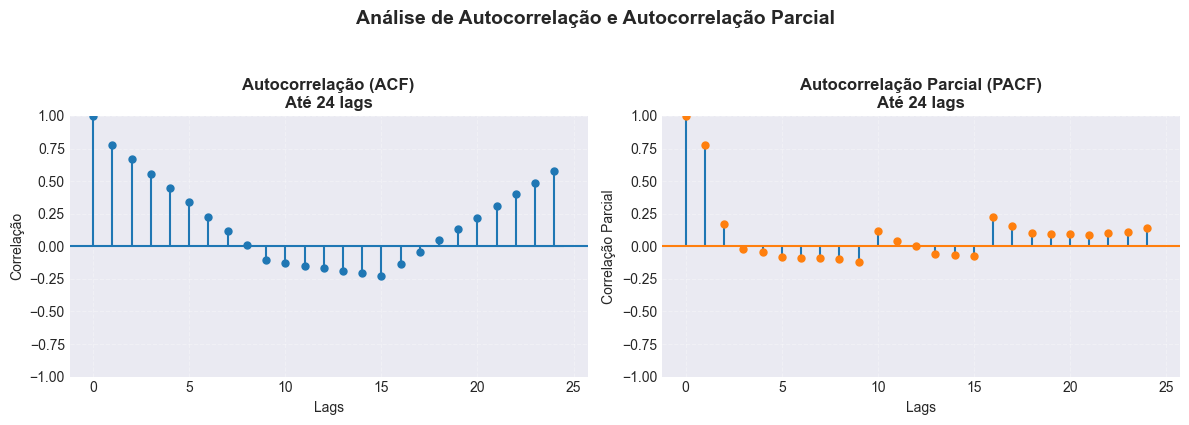

In [5]:
# Teremos entre 3 e 4 lags para para o nosso modelo baseline

plot_acf_pacf(df.requisicoes, lags=24)

In [6]:
# Pegando 80% dos dados do início ao fim
df_requisicoes_treino = df.requisicoes[:int(df.requisicoes.shape[0]*0.8)]

# Pegando 20% dos dados restantes para o nosso conjunto de teste
df_requisicoes_teste = df.requisicoes[:int(df.requisicoes.shape[0]*0.8):]

In [7]:
X, y = cria_atributos_defasados(df_requisicoes_treino, n_lags=4)

In [8]:
scores = cv_serie_temporal(
            X=X,
            y=y,
            model=LinearRegression(),
            window_size=24*7*2,
            horizon=10,
            n_splits=10,
            metric="mape",
            scale_method="standard", # "standard" ou "minmax"
            outlier_method="isolation_forest" # "winsor" "iqr" "zscore" "isolation_forest"
        )


Fold 1 | MAPE: 20.4120
Fold 2 | MAPE: 16.6833
Fold 3 | MAPE: 10.4055
Fold 4 | MAPE: 28.2871
Fold 5 | MAPE: 26.0578
Fold 6 | MAPE: 40.5791
Fold 7 | MAPE: 21.6452
Fold 8 | MAPE: 16.2102
Fold 9 | MAPE: 29.9406
Fold 10 | MAPE: 35.8687

Média MAPE = 24.6089


- O que é estacionariedade? Como verificamos se uma série temporal é estacionária?
- Como é feita a validação cruzada para séries temporais?
- O que é um modelo baseline?
- O que são PACF e ACF?
- Explique as diferentes técnicas aplicadas para tratamento de outliers e discuta os diferentes resultados obtidos.
- Como foi encontrado o parâmetro p do modelo baseline AR(4)
- Qual a importância dos valores dos betas definidos pelo modelo baseline? Como encontramos esses valores?
- Como funcionam as téncicas de normalização e padronização?
- Como funciona o algortimo isolation forest? Quais são os seus principais parâmetros?
- Quais são as premissas da técnica z-score?
- Existe alguma premissa recomendada para usar o StandardScaler?
- Quais são as principais métricas de regressão utilizadas?